In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix
import math

In [2]:
path = "CAPE_ALL.xlsx"
df = pd.read_excel(path,sheet_name=0)
df["Date"] = pd.date_range(start='1871-01-01',end='2025-02-01',freq='ME')
df = df.dropna(subset=['CAPE'])
df.reset_index(drop=True, inplace=True)
df.head()

,Date,P,D,E,CPI,Fraction,Rate GS10,Real Price,Real Dividend,Real Total Return Price,Real Earnings,Scale Earnings,CAPE,TR CAPE,Yield,Monthly Bond Returns,Real Bond Returns,Stock Real Return 10 Yr,Bond Real Return 10 Yr,Returns
0,1881-01-31,6.19,0.265,0.4858,9.419420,1881.041667,3.700000,207.242891,8.872272,383.409300,16.264717,30.090507,18.473952,24.135057,-0.010489,1.003636,2.422306,0.045353,0.056468,-0.011115
1,1881-02-28,6.17,0.270,0.4817,9.514585,1881.125000,3.693333,204.507131,8.949259,379.727725,15.966140,29.645842,18.147258,23.655503,-0.011393,1.003631,2.406798,0.046774,0.056199,-0.009425
2,1881-03-31,6.24,0.275,0.4775,9.514585,1881.208333,3.686667,206.827309,9.114986,385.446207,15.826930,29.495283,18.270119,23.767713,-0.013123,1.003625,2.415537,0.042423,0.054885,-0.012462
3,1881-04-30,6.22,0.280,0.4733,9.609669,1881.291667,3.680000,204.124477,9.188883,381.836216,15.532494,29.055158,17.950108,23.308850,-0.007504,1.003620,2.400307,0.045971,0.054635,-0.008665
4,1881-05-31,6.50,0.285,0.4692,9.514585,1881.375000,3.673333,215.445114,9.446440,404.485199,15.551823,29.197609,18.869719,24.456686,-0.008881,1.003615,2.433070,0.041157,0.054786,-0.013628


In [3]:
def get_real_bond_returns():
    bond_returns = [math.nan]*120
    for i in range(len(df)-120):
        ret = (df['Real Bond Returns'][i+120]/df['Real Bond Returns'][i])**(1/10) - 1
        # print(ret)
        bond_returns.append( ret ) 
    return bond_returns

df["Bond_Returns_10Y"] = get_real_bond_returns()

In [4]:
data = pd.DataFrame({})
data["Date"] = df["Date"]
data["CAPE_INV"] = 1/df["TR CAPE"]
data["CPI"] = df["CPI"].pct_change(periods=12).shift(2)
data["Bond_Returns_10Y"] = df["Bond_Returns_10Y"]
data["S&P Vol"] = df["P"].pct_change().rolling(12).std()
data["Inflation"] = df["CPI"].pct_change(12)  # NEEDS TO FIX THIS
data["Bond Vol"] = df["Real Bond Returns"].rolling(12).std()
data.set_index("Date",inplace=True)

In [5]:
# var_names = ["CAPE_INV", "Bond_Returns_10Y", "Inflation", "S&P Vol", "Bond Vol" ]
var_names = ["CAPE_INV", "Bond_Returns_10Y","S&P Vol", "Bond Vol" ]

def transform(data, const):
    return np.log(data + const)
def inverse_transform(data, const):
    return np.exp(data) - const

# const = [1e-6,0.06,0.20,0,0]
const = [1e-6,0.06,0,0]

variables = transform(data.loc['1925-01-01':, var_names], const)
# variables["Date"] = data.iloc[540:, "Date"]

In [6]:
# variables.describe()
variables.head()

,CAPE_INV,Bond_Returns_10Y,S&P Vol,Bond Vol
Date,,,,
1925-01-31,-2.635685,-2.930045,-3.516757,-2.379114
1925-02-28,-2.649269,-2.938477,-3.520554,-2.510018
1925-03-31,-2.616354,-2.969319,-3.493152,-2.633935
1925-04-30,-2.611199,-2.939828,-3.534612,-2.543176
1925-05-31,-2.636456,-2.932727,-3.548323,-2.517843


In [32]:
# variables.set_index("Date", inplace=True)
# data_test.head(12)

In [30]:
from sklearn.ensemble import RandomForestRegressor

X = []
y = []

features = len(variables.columns)
features_name = variables.columns

data_train = variables['1925-01-01':'1959-12-31']
data_test = variables['1960-01-01':'2024-12-31']

lags = 12

for i in range(lags,len(data_train)):
    X.append(data_train.iloc[i-lags:i,:])
    y.append(data_train.iloc[i]["CAPE_INV"])


In [31]:
X = np.array(X).flatten().reshape(len(X),lags*features)

In [32]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

RandomForestRegressor(random_state=42)

In [34]:
# now we can predict the future
X_test = data_train.iloc[-lags:,:].values.reshape(1,lags*features)
y_pred = []
y_actual = []

for i in range(lags,len(data_test)):
    yy = []

    pred_y = model.predict(X_test)

    y_pred.append(pred_y)
    y_actual.append(data_test.iloc[i]["CAPE_INV"])


    # model.fit(X_test, y_actual)
    # print(X_test.shape)
    X_test = np.append(X_test[:,features:], np.array(data_test.iloc[i - lags]).reshape(1,-1) , axis=1)


In [103]:
# xx = data_train.iloc[-lags:,:].values.reshape(1,lags*features)
# np.append(xx, np.zeros((1,features)), axis=1)

In [36]:
# y_actual

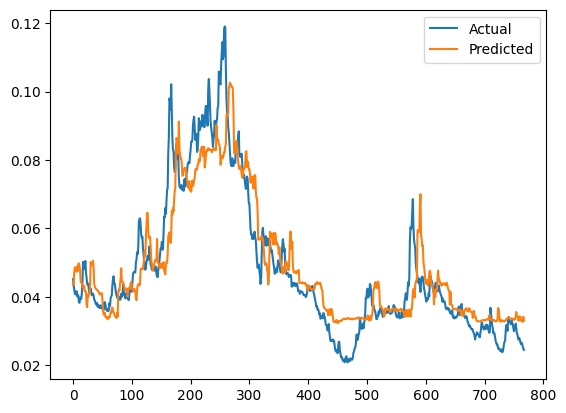

In [41]:
plt.plot(np.exp(y_actual) + const[0], label="Actual")
plt.plot(np.exp(y_pred) + const[0], label="Predicted")
plt.legend()

Rough

In [ ]:
from sklearn.ensemble import RandomForestRegressor

X = []
y = []

features = len(variables.columns)

data_train = variables['1925-01-01':'1959-12-31']
data_test = variables['1960-01-01':'2024-12-31']

lags = 12


for i in range(lags,len(data_train)):
    X.append(data_train.iloc[i-lags:i,:])
    y.append(data_train.iloc[i,:])

X_train = np.array(X).flatten().reshape(-1,features*lags)
y = pd.DataFrame(y)

# models = {}
# for i in y.columns:
#     y_v = (y[i].values)
#     print(X_train.shape, y_v.shape)
#     # models[i] = RandomForestRegressor(n_estimators=300, random_state=42, max_depth=10).fit(X_train, y_v)
#     # linear regression
    
        
#     models[i] = LinearRegression().fit(X_train, y_v)
    # models[i] = LogisticRegression().fit(X_train, y_v)

(408, 48) (408,)


NameError: name 'LinearRegression' is not defined

In [52]:
models

{'CAPE_INV': RandomForestRegressor(max_depth=10, n_estimators=300, random_state=42),
 'Bond_Returns_10Y': RandomForestRegressor(max_depth=10, n_estimators=300, random_state=42),
 'S&P Vol': RandomForestRegressor(max_depth=10, n_estimators=300, random_state=42),
 'Bond Vol': RandomForestRegressor(max_depth=10, n_estimators=300, random_state=42)}

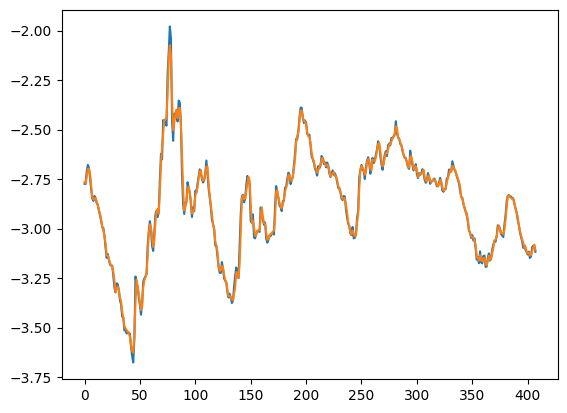

In [53]:
y_cape_inv = models["CAPE_INV"].predict(X_train)

# 
plt.plot(y["CAPE_INV"].values)
plt.plot(y_cape_inv)

In [54]:
forecast = []
initial_input = X_train[-1].reshape(1, -1)  # Ensure shape is (1, 5*lags)
steps = len(data_test)

for i in range(steps):
    next_step = []
    
    # Predict for each variable using the corresponding model
    for j in models.keys():
        prediction = models[j].predict(initial_input)[0]  # Predict the next step
        next_step.append(prediction)
    
    forecast.append(next_step)  # Append predictions for this time step
    
    

    # Update initial_input for the next prediction
    initial_input = np.append(initial_input.flatten()[features:], next_step).reshape(1, -1)  # Maintain (1, 5*lags)
    

In [55]:
forecast = pd.DataFrame(forecast, columns=var_names, index=data_test.index)  # Align columns and index
# forecast.head()

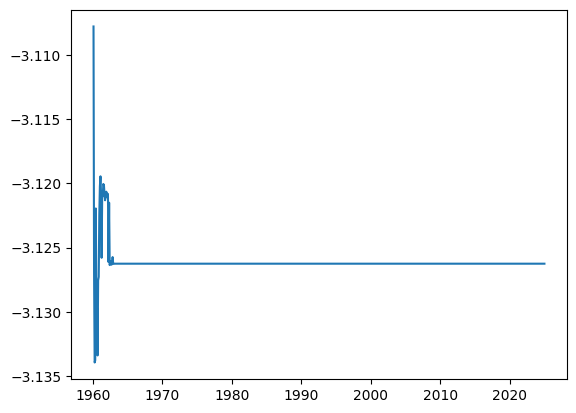

In [56]:
# plt.plot(data_test["CAPE_INV"], label="Actual")
plt.plot(forecast["CAPE_INV"], label="Forecast")

In [311]:
actual = []
predicted = []

# Train the Random Forest model on the training set
# rf.fit(X_train, y_train)

# Initialize X_test with the last `lags` rows from training data
X_test = np.array(data_train.iloc[-lags:, :]).flatten().reshape(1, 5 * lags)  # Shape: (1, 5*lags)

# Recursive forecasting loop
for i in range(len(data_test) - lags):
    # Predict the next time step
    y_pred = rf.predict(X_test)  # Predicted shape: (1, 5)S

    # Append the actual and predicted values for evaluation
    y_test = np.array(data_test.iloc[i, :])  # Actual values at the current time step
    actual.append(y_test.tolist())
    predicted.append(y_pred.flatten().tolist())

    # Update X_test for the next prediction
    # Combine the current prediction with the existing lagged input
    X_test = np.append(X_test.flatten(), y_pred.flatten())  # Append the predicted values
    X_test = X_test[5:].reshape(1, 5 * lags)  # Keep the last `lags` rows as input

    # rf.fit(X_test, y_test)


ValueError: Found input variables with inconsistent numbers of samples: [1, 5]

In [ ]:
actual = []
predicted = []

# Train the Random Forest model on the training set
# rf.fit(X_train, y_train)

# Initialize X_test with the last `lags` rows from training data
X_test = np.array(data_train.iloc[-lags:, :]).flatten().reshape(1, 5 * lags)  # Shape: (1, 5*lags)

# Recursive forecasting loop
for i in range(len(data_test) - lags):
    # Predict the next time step
    y_pred = rf.predict(X_test)  # Predicted shape: (1, 5)S

    # Append the actual and predicted values for evaluation
    y_test = np.array(data_test.iloc[i, :])  # Actual values at the current time step
    actual.append(y_test.tolist())
    predicted.append(y_pred.flatten().tolist())

    # Update X_test for the next prediction
    # Combine the current prediction with the existing lagged input
    X_test = np.append(X_test.flatten(), y_pred.flatten())  # Append the predicted values
    X_test = X_test[5:].reshape(1, 5 * lags)  # Keep the last `lags` rows as input

    # rf.fit(X_test, y_test)


ValueError: Found input variables with inconsistent numbers of samples: [1, 5]

In [304]:
actual_ = np.array(actual)
predicted_ = np.array(predicted).reshape(-1,5)

In [310]:
predicted_[100:110]

array([[-2.60568754, -2.64054036, -1.71734892, -3.49549299, -1.63809882],
       [-2.60568754, -2.64054036, -1.71734892, -3.49549299, -1.63809882],
       [-2.60568754, -2.64054036, -1.71734892, -3.49549299, -1.63809882],
       [-2.60568754, -2.64054036, -1.71734892, -3.49549299, -1.63809882],
       [-2.60568754, -2.64054036, -1.71734892, -3.49549299, -1.63809882],
       [-2.60568754, -2.64054036, -1.71734892, -3.49549299, -1.63809882],
       [-2.60568754, -2.64054036, -1.71734892, -3.49549299, -1.63809882],
       [-2.60568754, -2.64054036, -1.71734892, -3.49549299, -1.63809882],
       [-2.60568754, -2.64054036, -1.71734892, -3.49549299, -1.63809882],
       [-2.60568754, -2.64054036, -1.71734892, -3.49549299, -1.63809882]])

In [306]:
len(predicted_[:,0]),len(actual_[:,0])

(779, 779)

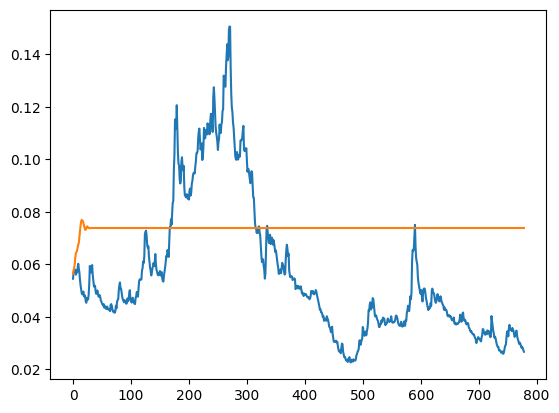

In [307]:
cape_inv_true = actual_[:,0]
cape_inv_pred = predicted_[:,0]

plt.plot(np.exp(cape_inv_true) - const[0], label="True")
plt.plot(np.exp(cape_inv_pred) - const[0], label="Pred")

In [244]:
cape_inv_pred.shape

(778, 5)

In [129]:
def invert_transform(forecast, constant):
    inverted = np.exp(forecast)-constant
    return inverted

def var_forecast(training_data):
    var_model = VAR(training_data)
    fitted = var_model.fit(12)
    input = training_data.iloc[-13:-1].values
    forecast = fitted.forecast(input, steps=120)
    forecast = pd.DataFrame(forecast, columns=training_data.columns)
    forecast = invert_transform(forecast,const)
    return forecast


In [130]:
start_date = pd.to_datetime('1926-01-01')
forecast_dates = pd.date_range(start='1960-01-01',end='2007-06-30',freq='m')
forecasted_earnings_yelds = np.zeros(forecast_dates.shape[0])

for i in range(forecast_dates.shape[0]):  
    end_date = forecast_dates[i]
    start_date = start_date # end_date - pd.DateOffset(years=50) # 
    forecasted_earnings_yelds[i] = var_forecast(variables[start_date:end_date])['CAPE_INV'].iloc[-1] 

C:\Users\Ishit\AppData\Local\Temp\ipykernel_2752\2430865936.py:2: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(start='1960-01-01',end='2007-06-30',freq='m')
c:\Users\Ishit\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Ishit\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Ishit\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Ishit\AppData\Local\Programs\Python\Pyt

In [163]:
data.tail()

,CAPE_INV,CPI,Bond_Returns_10Y,S&P Vol,Inflation,Bond Vol,P
Date,,,,,,,
2024-09-30,0.028042,0.028948,-0.014818,0.025261,0.024406,1.114968,NaN
2024-10-31,0.027332,0.025307,-0.020135,0.019174,0.025979,0.946031,NaN
2024-11-30,0.026710,0.024406,-0.022266,0.018243,0.027494,0.885995,NaN
2024-12-31,0.026372,0.025979,-0.023901,0.016427,0.028237,0.869961,NaN
2025-01-31,0.027038,0.027494,-0.028506,0.020687,0.022527,0.872997,NaN


C:\Users\Ishit\AppData\Local\Temp\ipykernel_2752\370324625.py:1: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecasted_earnings_yelds = pd.DataFrame(forecasted_earnings_yelds, index=pd.date_range(start='1970-01-01',end='2024-06-30',freq='m'))


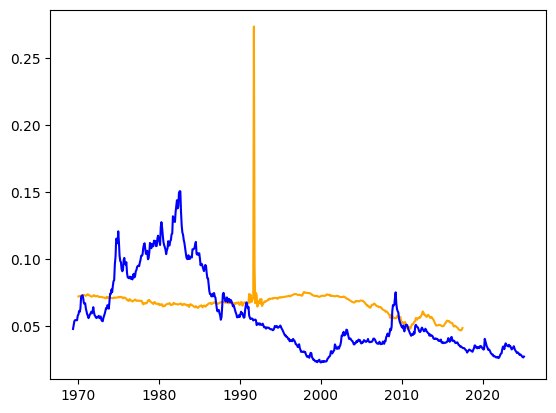

In [169]:
forecasted_earnings_yelds = pd.DataFrame(forecasted_earnings_yelds, index=pd.date_range(start='1970-01-01',end='2024-06-30',freq='m'))
# forecasted_earnings_yelds.plot(color='orange')
plt.plot(forecasted_earnings_yelds, color='orange')
plt.plot(data["CAPE_INV"][940+120:], color='blue')

In [151]:
#predict stock returns
def stock_return(current_earning_yeld, predicted_earning_yeld,epsgr,pay_out_ratio):
    delta_cape = ((predicted_earning_yeld**-1)/(current_earning_yeld**-1))**(1/10) -1
    div_yeld = predicted_earning_yeld*pay_out_ratio
    return delta_cape+epsgr+div_yeld

predicted_returns = np.zeros(forecast_dates.shape[0])
eps_growth = 0.06
pay_out_ratio=0.48

for i in range(forecast_dates.shape[0]):
    predicted_ey = forecasted_earnings_yelds.iloc[i]
    current_ey = data.loc[forecast_dates[i],'CAPE_INV']
    predicted_returns[i] = stock_return(current_ey,predicted_ey,eps_growth,pay_out_ratio)

# predicted_returns = pd.Series(predicted_returns,index=pd.date_range(start='1970-01-01',end='2017-06-30',freq='m'))
# predicted_returns.plot(color='orange', figsize=(20,6))

plt.plot

C:\Users\Ishit\AppData\Local\Temp\ipykernel_2752\509493664.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  predicted_returns[i] = stock_return(current_ey,predicted_ey,eps_growth,pay_out_ratio)


<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

In [139]:
len(predicted_returns)

570

In [142]:
def get_nominal_returns():

    nominal_returns = [math.nan] * 120


    for idx in range(120, len(df)):
    # Loop to account for reinvested dividends
        R_t_1 = 0
        R_t = 0
        P_t_1 = 0
        P_t = 0
        for i in range(120):
            if i == 0:
                R_t  = df["P"].iloc[idx-120+i]
                P_t = df["P"].iloc[idx-120+i]
            else:
                P_t_1 = df["P"].iloc[idx-120+i-1]
                d_t_1 = df["D"].iloc[idx-120+i-1]
                R_t_1 = (R_t/P_t) * (P_t_1 + d_t_1/12)

                R_t = R_t_1
                P_t = P_t_1

            ret = (R_t / df["P"].iloc[idx-120]) ** (1/10) - 1    
        nominal_returns.append(ret)
        
    return nominal_returns

nominal = get_nominal_returns()

In [148]:
len(nominal[-570:])

570

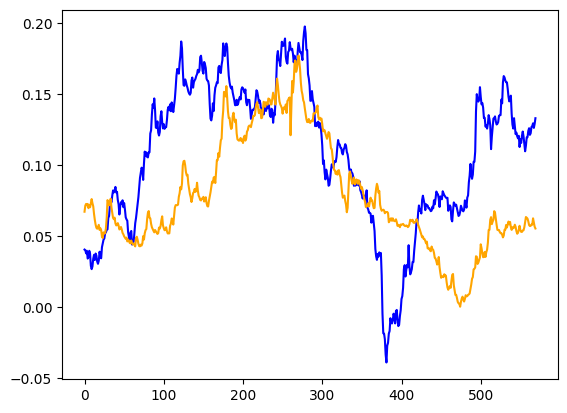

In [170]:
plt.plot(nominal[-570:], color='blue')
plt.plot(predicted_returns, color='orange')

In [171]:
# rmse
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(nominal[-570-120:-120], predicted_returns))
rms

0.052810573462403

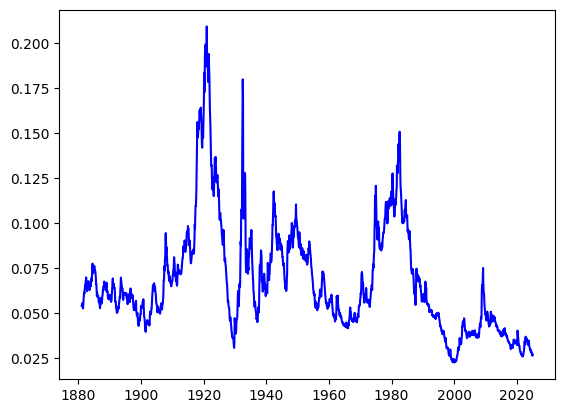

In [164]:
plt.plot(data["CAPE_INV"], color='blue')